# AutoPCA - or ten ways to Solve a Problem in Pandas/Numpy

This is an actual problem that took me a few days to solve. I go through my own thinking and learning as I went. Along the way there are a number of very interesting and useful nuggets along the way that are worth knowing, and are not commonly known. Bear with me and I expect that it will be educational even if you are an old-timer.

Some parts of this are about python and pandas, while others are about numpy and mathematics. Most of it would be useful for intermediate/advance data analysts.

I am going to be using 64bit Python 3.7.3, Pandas 0.25.1, and Numpy 1.17.1 on a Windows 10 machine.

In [1]:
import numpy as np
from numpy.random import random as rnd
import scipy
import scipy.linalg as la
from sklearn.decomposition import PCA

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
pd.show_versions()



INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.1
numpy            : 1.17.1
pytz             : 2019.2
dateutil         : 2.8.0
pip              : 19.2.3
setuptools       : 41.2.0
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.8.0
pandas_datareader: None
bs4              : None
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       :

## The Problem

I started out with a dataframe that had been measured every second, although some variables were very slowly changing. It was clearly extremely redundant, so my first thought was dimensionality reduction. The data covered some 5 months, so there were `5*30*24*60*60` or nearly 13 million rows, and about 140 columns. It was (dis-)organized as a set of csv files (about 15GBs), one for each hour, grouped in directories of days, which were grouped in directories of months.

CSV files are large and reading them is slow, so the first task was to convert them to some compressed format. The problem is that the entire dataset is so big that the whole dataframe won't load into memory at once. 13million * 140 * 8 is over 14GBs, which is all the memory that I had.

Currently the file format that I find "best" is the `hdf` format, especially because support for it is already there in `pandas`. An `hdf` file can store multiple `pandas` data frames, in a compressed format with quite fast reads and writes. There are a number of compression options. I compressed the 14 GBs of directories and files into a six separate dataframes, and put all the six dataframes into a 3.75 GB `hdf` file.

## Preliminaries

Reading large amounts of data itself is a serious matter. Here are some invaluable techniques that were useful.

### Nugget 1. Read all csv files and save in one big file

You might think that you need a number of loops to cover all the months, days, and hours, but with the `glob` module collected all `csv` files scattered in a number of subdirectories is just a one-liner (line 4 below).

    import pandas as pd
    import glob
    with pd.HDFStore(r'c:\PyProj\persecond\alldata.h5') as hdf:
        for n, file in enumerate(glob.glob(r"c:\PyProj\persecond\**\*.csv", recursive=True)):
            hdf[f'/d{n:05d}'] = pd.read_CSV(f)

### Nugget 2. HDF files

As mentioned above `hdf` files are a nice fast and compressed format. If you simply want to save a single dataframe in a file, `dataframe.to_hdf(filepath, key, complevel, complib)` is easiest. To read it, you give the command `pd.read_hdf(filepath, key)`.

Since we are going to write multiple files into one hdf file, it is more efficient to keep the file open during the entire process. Line 3 opens an hdf file for the duration of the `with` statement, and automatically closes it at the end. An open `hdf` file can be used just like a dictionary, to store a dataframe, just pick a unique `key` and store it there.

    ncol = 30
    with pd.HDFStore(r'c:\PyProj\persecond\alldata.h5', mode='r') as hdf:
        for n in range(6):
            with pd.HDFStore(r'c:\PyProj\persecond\sixdata.h5', complevel=9, complib='blosc:lz4') as six:
                df = pd.DataFrame()
                for key in hdf.keys():
                    df = df.append(hdf[key].iloc[:,n*ncol:(n+1)*ncol], ignore_index=True, sort=False)
                    six[f'/data{n}] = df

The method of writing and `hdf` file used here is the least flexible, but because of that it is the fastest and gets the most compression. See the `pandas` documentation on `hdf` [here](https://pandas.pydata.org/pandas-docs/stable/reference/io.html#hdfstore-pytables-hdf5).

Other methods allow adding rows or columns to stored datasets, loading partial datasets, etc. That way we can deal with datasets that are too big to fit in memory (See the long documentation for [pytables](http://www.pytables.org/usersguide/introduction.html)). Had we used that method, we could have stored the entire data in one table, but at the cost of slower read/writes and larger file size.

Since the csv files are huge, the above code can't be run. Instead we will create some fake data of the same size and shape, so that we can continue our experiments.

## Use simulated data

Here we make a single feature, `x`, and use random numbers, but in a way that makes it random but smooth and slowly changing. We don't bother putting it as a `pandas.Series`, because we are not really going to use much of pandas abilities here.

### Nugget 3. rdParams

If you use `matplotlib`, you can globally set your preferred styles, colors, fonts etc at the start by using `plt.rcParams` as shown in line 1 of the box below. You can get a list of all possible parameters that can be set, as well as many more customization tips from the [documentation](https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html).

All global preference can be overridden for an individual plot.

### Nugget 4. Pandas paramters

Similarly you can set global preferences for `pandas` output, like the number of digits, the maximum width of a dataframe display, etc, as documented [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html). As before, all global preference can be overridden for an individual display. For a fancier amount of styling you can see [this](https://mode.com/example-gallery/python_dataframe_styling/). We don't really show any use of these here, but it is very useful when needed.

After creating the data in `x`, we look at the entire series in the first plot, and zoom in on a random 180 second period in the second plot.


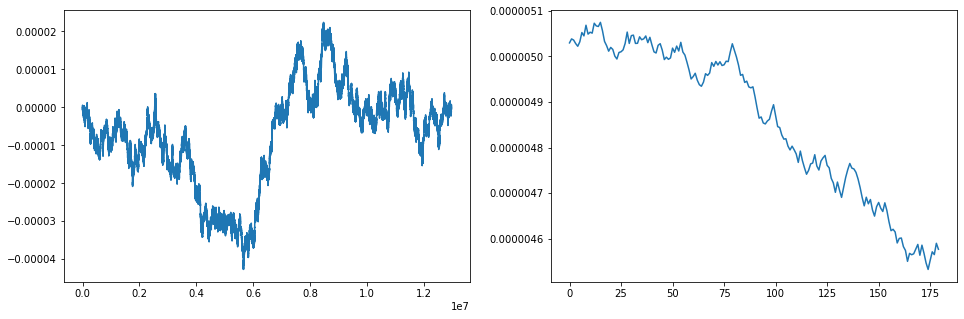

In [2]:
plt.rcParams['figure.figsize'] = [16, 5]

nrows = 5*30*24*60*60
np.random.seed(2)
x = np.cumsum(np.cumsum(rnd(nrows)-0.5)*0 + (rnd(nrows)-0.5)*50) * 1e-9
x = x - x[-1]*np.arange(nrows)/nrows

plt.subplot(121)
plt.plot(x)
plt.subplot(122)
rnd60 = int(rnd(1)*nrows//60)
plt.plot(x[rnd60*60:(rnd60+3)*60])


## Dimensionality Reduction using PCA

One of the more standard techniques of reducing dimensionality is **Principal Components Analysis** (PCA) (sklearn documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). An example is best to illustrate, so imagine a tailor's list of measurements of sleeve, collar, chest, waist, ... What is intersting is that many stores will sell a shirt with just one number to indicate the size. Given that number they estimate what the others numbers ought to be. Store bought shirts never fit quite as well as a tailored shirt, unless you are a perfectly average person, but they are good enough for most.

Similarly, given a large number of features (think tailor's measurements), PCA tries to create a few linear combinations of the features to create one or two components (think shirt size), such that we can reconstruct the original features by taking linear combinations of these components. The smaller the number of components, the higher the reconstuction error (the difference between the actual features and the features reconstructed from components). If we allowed two numbers for store shirts, one indicating an overall height, and one for width, then store bought shirts would be able to fit many more people with a better fit.

### PCA with just one Feature

Each feature (column) of my data is a time series, and my problem was to find the "appropriate sampling rate" for each feature. There are a number of ways to approach this problem. From a signals perspective, we could try to take a Fourier Transform of the time series, and find out at what frequencies most of the energy was located, and then sample as double that frequency or a bit more.

The data was sampled once every second. If we grouped periods of 60 seconds, and tried to summarize each minute by just one number, could we do a good job? This looks like a job for PCA. Here is how we could answer the question.


In [3]:
# Demo of what reshape does
np.arange(30).reshape(-1,5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29]])

In [4]:
x_minutes = x.reshape(-1, 60)
pca = PCA(n_components=3).fit(x_minutes)
ev = pca.explained_variance_ratio_
print("Explained variance:", ev)
print("Cumulative Unexplained variance:", 1 - np.cumsum(ev))


Explained variance: [9.99988179e-01 7.21022229e-06 1.78835454e-06]
Cumulative Unexplained variance: [1.18205844e-05 4.61036216e-06 2.82200762e-06]


The explained variance is a number between 0 and 1, which assigns how much of the data variation is explained by a single component. Usually these are listed from the highest to the lowest. The numbers are additive, so if we use all three component, then they would explain the sum of the three numbers.

The three numbers in the cumulative unexplained (or residual) variance is how much error remains after one, or two, or three components are used to reconstuct the data.

To understand what this means, we will compress the each minute's 60 data points into just three numbers (components). Then we use these components to reconstruct the original data (brown colored line in the right graph below). It is not a perfect reconstruction.

We do the same with just two components (green line in the right graph below), and finally with just one component. Obviously just one component does not do a very good job if you look very closely (blue line in the right graph below), but when you look at the overall picture, the error is hardly noticable (few blue dots barely visible in the left graph below).

(216000, 3)


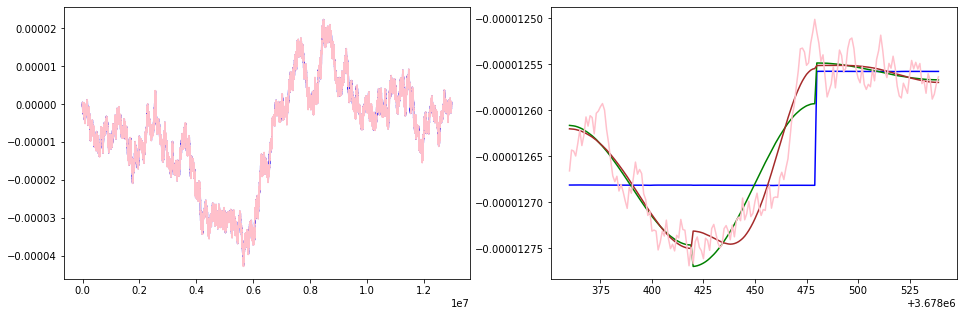

In [5]:
# convert the data to get all three components
components = pca.transform(x_minutes)
print(components.shape)
# kill the second and third components, so we only have one component
onecomp = components.copy()
reconstructed_x3 = np.ravel(pca.inverse_transform(onecomp))
onecomp[:,2] = 0
reconstructed_x2 = np.ravel(pca.inverse_transform(onecomp))
onecomp[:,1] = 0
reconstructed_x1 = np.ravel(pca.inverse_transform(onecomp))
# now reconstruct an approximation to the original data from just that one component
plt.subplot(121)
plt.plot(reconstructed_x1, color="blue")
plt.plot(x, color="pink")
plt.subplot(122)
rnd60 = int(rnd(1)*nrows//60)
plt.plot(np.arange(rnd60*60, (rnd60+3)*60), reconstructed_x1[rnd60*60:(rnd60+3)*60], color="blue")
plt.plot(np.arange(rnd60*60, (rnd60+3)*60), reconstructed_x2[rnd60*60:(rnd60+3)*60], color="green")
plt.plot(np.arange(rnd60*60, (rnd60+3)*60), reconstructed_x3[rnd60*60:(rnd60+3)*60], color="brown")
plt.plot(np.arange(rnd60*60, (rnd60+3)*60), x[rnd60*60:(rnd60+3)*60], color="pink")



## Log Liklihoods for Anomaly Detection

While we are here, it may be worth mentioning a tangent point. Finding one number that by itself can predict 60 is quite an impressive feat. But it relies on the fact that the data has some common patterns. If the data had been simply random, it would not be possible to compress even a little bit.

Another information available from a PCA is the "log-liklihood" of a sample. If I give some 60 numbers, how well can the components predict it. If the sample of 60 numbers comes from data with similar patterns, it should be easy to predict. If it does not follow the patterns of the data, then the prediction would not be so good.

Using the tailor analogy, if we did a PCA for a large American population, then we try to fit these shirts to some people from Brazil, the fit might not be very good. Even among Americans, there may be individual that are different from the norm. This is called anomaly detection.

So here, we obtain a "log-liklihood" score for each 60 second interval. The lower the score the more unusual the interval is. Looking at the graphs, we can see that the most significant anomaly occurs somewhere near 205000.


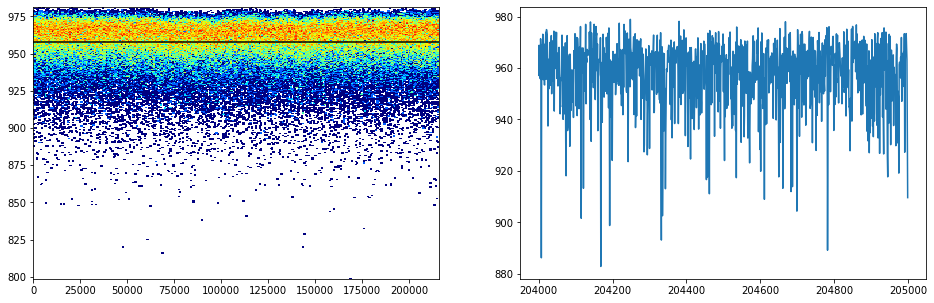

In [6]:
sscore = pca.score_samples(x_minutes)
plt.subplot(121)
plt.hist2d(np.arange(len(sscore)), sscore, bins=(300,500), cmap=plt.cm.jet, norm=mcolors.LogNorm())[0]
plt.plot([0, len(sscore)], np.repeat(pca.score(x_minutes), 2), color='black')

plt.subplot(122)
rnd60 = 204000
plt.plot(np.arange(rnd60,rnd60+1000), sscore[rnd60:rnd60+1000])


The black line in the graph above is the average log-liklihood, so points near or above the black line are "typical". If we are looking for anomalies, points with a log-liklihood of under 800 or 850 are where the suspects are. Note that there must be some reason that the y-axis starts below 700. A careful examination with a magnifying glass shows a small blip sitting on the x-axs around x=205,000. In fact that is why the graph on the right zooms in on that are, to show the culprit in detail.

Zooming in further, we can locate the anomaly precisely at 204216. If we plot the data for that and the previous and next minute, we can see that the fit is not very good in the middle interval.

### Nugget 5.

Until now, we had been using `plt.plot` to plot graphs of our time series. Although `x` had nearly 13 million points, while the screen image has not much more than around 1000 points, there seem to be thousands of points that are going to be plotted right on top of each other. 

This has three problems.

* The plot actually saves each of the 12 million points used to generate it, wasting about 100 megabytes for each plot.
* The plot takes a long time to render because it has to draw each of those points on the screen
* The plot gives no indication of where there is only one point, and where one point has been drawn over a thousand times

When your time series has a very large number of points, a better way that avoids all these problems is to draw a histogram. This only draws points, instead of connecting them with lines. It colors them by the number of times the point is hit.The darker colors indicate only one point, while the brighter ones have a lot of hits.

In Line 8 above, you can see that we have used the histogram feature to draw the left plot.

#### Sub-nugget 5.1

A plain histogram plots the color intensity based on the number of points that are plotted on top of each other. Since this number ranges from 1 to 1000 or so, the range is so large that colors will not distiguish features very clearly. In such a situation, the addition of the word `norm=mcolors.LogNorm()` in line 8, makes it so that larger numbers are compressed, while smaller number get more room in the color-space. So, for example, there will be as much difference in the colors between 3 and 6 as between 300 and 600.

Usually this is the effect that we want. Try out both with and without to see what looks better to you.

### Anlayzing the anomaly

In the followinng graph, we have focused in on the worst cast anomaly in the center, and one minute intervals on either side. There does not appear to be anything very unusual here. Partly this is because we have an extremely good fit (because the data is artificial).

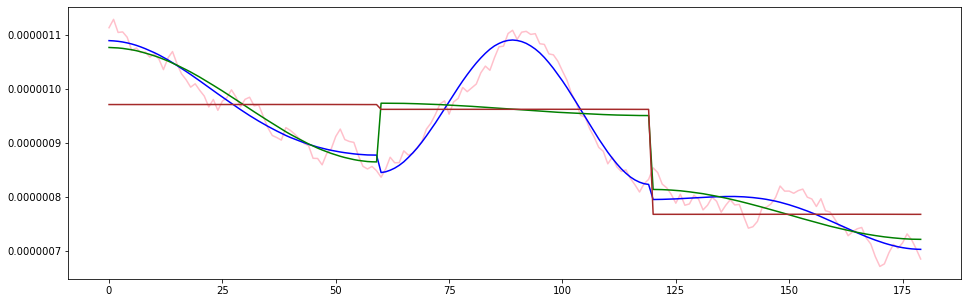

In [7]:
anomaly = 204216
plt.plot(x[(anomaly-1)*60:(anomaly+2)*60], color="pink")
plt.plot(reconstructed_x3[(anomaly-1)*60:(anomaly+2)*60], color="blue")
plt.plot(reconstructed_x2[(anomaly-1)*60:(anomaly+2)*60], color="green")
plt.plot(reconstructed_x1[(anomaly-1)*60:(anomaly+2)*60], color="brown")


## Overlapping Windows

As can be seen in the previous graphs, the reconstructed data has jumps at every minute. This is because the variable `x_minutes` broke rows at every 60th second, so the first row is `x[0:60]`, the next is `x[60:120]` and so on. At the end, it had `nrows//60` rows total, so the total size of the `x_minutes` matrix was the same as the size of `x`.

If instead we used overlapping rows so that the first row is `x[0:60]`, the next is `x[1:61]`, and so on, we would get many more rows. In fact the size of the resulting matrix would be nearly 60 times the size of `x`, which would put a strain on the memory.

### Nugget 6. Stride Tricks for overlapping windows

There is a very cute and useful technique hidden inside numpy (for a very good reason which we will mention soon). It is called `stride_tricks` (documented [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.stride_tricks.as_strided.html)). Normally, all `numpy` arrays are 1-dimensional. Multidimensional arrays are stored as a 1-dimensional list of numbers, and then a separate track is kept of the size of each of the dimensions, so that we can calculate the offset of any number.

Every array has a `shape` and a `stride`. The shape gives the number of elements in each dimension. The stride gives the number of bytes to move to go to the next element in that dimension. For example, in a plain 2-dim matrix `x` with `x.shape = (n,m)`, the `stride` of `x` would typically be `(8*m, 8)`, indicating that from the starting element `x[0,0]`, we would find `x[0,1]` located exactly 8 bytes later, and `x[0,2]` would be 8 bytes afer that (because a `dtype` of `float` takes 8 bytes to store a number). After `m` such numbers, we have complete a row, so we can start storing the next row. This means that to go from `x[0,0]` to `x[0,1]` we need to take a stride of `8*m` bytes.

If we play with these strides we can make very unusual arrays. So unusual that writing to them can have very confusing effects (see example A below). So unusual that you can crash your program by accidentally writing in areas where you shoudn't. But used carefully, this is a very useful trick.

**Example A:** If `a.shape = (3,4)` and `a.strides =(0,0)` then `a` looks to all the world as if it has 3 rows and 4 columns, but whichever of these 12 numbers you refer to, the stride calulations all send you to the same byte location. There is only has one number. If you set any location, all the number of the matrix change to that number.

**Example B:** consider the array made by `b = np.arange(15).reshape(3,5)`. If we change the shape to `(3,3)` and the strides to `(5*8, 8)` then this would become a 2-dimensional array with three columns which are the diagonals of `b`. Since we are not sure exactly what `dtype` the `b` array has, intead of a setting `strides` to `(40, 8)` it would be better to set it to `(5*b.strides[1], b.strides[1])`.

**Example C** What we want to do is to take an 1-dim array, and make its overlapping windows into rows. To do this we set its strides to be `(8, 8)`. Instead of explaining, just look at what this does to the array.

Note that `x.strides` is not a numpy array. It is a plain python immutable tuple.


In [8]:
print("Example A:")
a = np.array([5])
a_strided = np.lib.stride_tricks.as_strided(a, (3,4), (0,0))
print("    A 3x4 matrix consisting of just one number:")
print(a_strided)
a_strided[2,3] = 2
print("    After changing only one number of the matrix:")
print(a_strided)

print("\nExample B:")
b = np.arange(15).reshape(3,5)
print("    The original matrix:")
print(b)
b_strided = np.lib.stride_tricks.as_strided(b, (3,3), (6*b.strides[1], b.strides[1]))
print("    The matrix of its diagonals:")
print(b_strided)
print("    The original matrix after setting one of the columns of the diagonal matrix to -1")
b_strided[:,1] = -1
print(b)

print("\nExample C:")
c = np.arange(10)
c_window = 5
print("    The original 1-dim matrix")
print(c)
c_overlap = np.lib.stride_tricks.as_strided(c, (len(c) - c_window + 1, c_window), (c.strides[0], c.strides[0]))
print("    Overlapping windows of size 5")
print(c_overlap)


Example A:
    A 3x4 matrix consisting of just one number:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
    After changing only one number of the matrix:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]

Example B:
    The original matrix:
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
    The matrix of its diagonals:
[[ 0  1  2]
 [ 6  7  8]
 [12 13 14]]
    The original matrix after setting one of the columns of the diagonal matrix to -1
[[ 0 -1  2  3  4]
 [ 5  6 -1  8  9]
 [10 11 12 -1 14]]

Example C:
    The original 1-dim matrix
[0 1 2 3 4 5 6 7 8 9]
    Overlapping windows of size 5
[[0 1 2 3 4]
 [1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]
 [4 5 6 7 8]
 [5 6 7 8 9]]


We are going to go with the example C above, to create an array `xov` of overlapping windows. This is an enormous array, with shape `(12959941, 60)`, but it actally takes no extra space, because it is just sharing the space with the already existing `x`.

If we ever try to copy `xov`, the size would suddenly become the full size of `60 * 12959941 * 8` bytes, roughly 6.2 Gigabytes.

We will try to do a PCA, but open up a `Task Manager` window on the side, to watch the memory.
<img src="TaskManager.png" width=600>


In [9]:
ncol = 60
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
print(xov.shape)
%time pca = PCA(n_components=3).fit(xov)

ev = pca.explained_variance_ratio_
print("Explained variance:", ev)
print("Cumulative Unexplained variance:", 1 - np.cumsum(ev))


(12959941, 60)
Wall time: 1min 25s
Explained variance: [9.99988191e-01 7.19536395e-06 1.79127817e-06]
Cumulative Unexplained variance: [1.18090871e-05 4.61372316e-06 2.82244499e-06]


My plan had been to consider even larger moving windows, for example 300 (for a 5 minute window) or even 3600 (for an hour wondpw), but as we can see from the above statistics, at 60 seconds, we hit the top of the 16 GB memory, and it took over 1 minute to do the computations. One of my constraints is that this computation needs to be done interactively, so we have a maximum of 1 to 3 seconds before user annoyance sets in.

It is evident that somewhere along the way, PCA tries to make a copy of the `x` array, and nearly throws a memory bomb.

So how can we reduce its memory footprint?

And how can we speed it up?

## Idea 2

PCA is really a very simple procedure (in terms of matrices). Given a matrix `xov`,

    x0 = xov - np.mean(xov, axis=0)
    xtx = x0.T @ x0
    scipy.linalg.eigh(xtx, eigvals=(ncol-2, ncol-1))

There are three steps.

1. Subtract the mean from each column.
2. Compute the matrix product of `x.T` and `x`, where `x.T` refers to the transpose of `x`. (more on this later)
3. Compute the eigenvalues and eigenvectors of the product. `eigh` is the preferred routine here, because `xtx` is symmetric. **Warning** there is a `numpy.linalg.eigh` and a `scipy.linalg.eigh` and they differ slightly. The `scipy` version allows the `eigvals=` parameter which makes it go faster because it only computes the few specified eigenvalues and their eigenvectors.

But computing `x0` gets rid of all the compaction we got from `stride_tricks`.

## Idea 3

Since all the columns are nearly identical, they all have ***nearly*** the same mean, so if we center the `x` before we make `xov`, we will be nearly correct:

    x -= np.mean(x)
    xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
    xtx = xov.T @ xov
    scipy.linalg.eigh(xtx, eigvals=(ncol-2, ncol-1))

This is an approximation to the exact answer, but the approximation is very small. Also the answer does not have any *exact* significance. It is really an approximate question that is being asked.

But, when we try it below, you can see we still have memory issues.

### Mini-Nugget 6.1

Note that since `x` and `xov` share their data, once I subtract the mean from `x`, it automatically gets subtracted from `xov`, so we don't have to do line 2 below. On the other hand, that is a trivial saving of time, and can be potentially very confusing to the reader (or yourself a few days later), so it is best to either leave the full statement there, or at least a comment as below.


In [16]:
x -= np.mean(x)
# no needed to repeat the next line because x and xov share their data
# xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
%time xtx = xov.T @ xov
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))


Wall time: 1min 8s
Wall time: 0 ns
Explained Variance: [9.99988191e-01 7.19536398e-06 1.79127818e-06]


The time is being used almost entirely in the matrix multiplication. Fortunately there are other ways to multiply matrices, so we can see if we can improve on this.

## Idea 4

**Einstien Summation** notation is an amazingly compact way to express all kinds of "Tensor" operations, which include matrix multiplications as well as matrix transpose. Without going into too much detail, a string describe the operation that you want to do. If there are multiple arrays, the indices to each array are separated by commas in the string. Repeated indices indicate summation over that index.

So `a = np.einsum("ki,kj", x, x)`, does the computation:
$$a_{i,j} = \sum_{k} x_{k,i} x_{k,j} $$
When we try this, it stays within memory limits and is faster, although not fast enough for comfortable interactive use.

The output can be converted to `expained_variance` and other scores without much difficulty or computation, but right now we are focused on getting the speed up, so we defer that to a later stage.

Notice that the bottleneck is still the matrix multiplication speed.

In [11]:
x -= np.mean(x)
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
%time xtx = np.einsum("ki,kj", xov, xov)
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))

Wall time: 31.3 s
Wall time: 1.14 s
Explained Variance: [9.99988191e-01 7.19536393e-06 1.79127816e-06]


Ok, that reduced the time of multiplication by a factor of two, but it is still substantial.

##  Clever Idea 5

Another flashbulb moment! We have already made one approximation. How about another one?

Looking at the formula in Idea 4, you can see that `xtx[i,j]` is exactly the dot product of `xov[:,i]` and `xov[:,j]`. An approximation is that, if `i<=j` the dot product of `xov[:,0]` and `xov[:,j-i]` should be nearly the same. Because `xov[:,i]` is just `xov[:,0]` shifted by `i` places. Similarly, `xov[:,j]` is just `xov[:,j-i]` shifted by the same `i` places. So except for some of the terms at the ends of the vector, the bulk of the sum should be indentical.

So instead of computing the dot product of every column with every other column, we can compute the dot product of column 0 with every other column, and then fill in the rest of the matrix. Suddenly we have converted 3600 dot products into only 60.

Another interesting fact is that the `eigh` function expects a symmetric matrix, so it only picks values from the lower triangular part, and ignores the upper triangular entries of `xtx`. This makes our task a bit easier to fill in the `xtx` matrix.

In [12]:
x -= np.mean(x)
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
xtx = np.zeros([ncol, ncol])
%time xtx[:,0] = np.einsum("i,ij", xov[:,0], xov)
for col in range(1,ncol):
    xtx[col:, col] = xtx[:-col,0]
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))

Wall time: 479 ms
Wall time: 0 ns
Explained Variance: [9.99988193e-01 7.19378637e-06 1.79113793e-06]


SUCCESS! we have a fast and low memory version for the first time. This is 60 times faster than before. The numbers are not the most accurate, but the errors will be small, especially with the huge length of data that we have.

But we are interpid and will not be stopped. We will defeat our successes with further successes.

## Idea 6

Because of our approximation in idea 5, the `xtx` matrix has become not just symmetric but Toeplitz! Every diagonal just carries the same number. Since `numpy` has some special commands to create Toeplitz matrices, we can replace the loop in lines 5 and 6 of Idea 5, with a simple statement:
`xtx = scipy.linalg.toeplitz( np.einsum(...) )`
This will take that result and fill out the matrix.
This does not accomplish much in terms of memory or speed, but does make the program shorter and simpler to read.

In [13]:
x -= np.mean(x)
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
%time xtx = la.toeplitz(np.einsum("i,ij", xov[:,0], xov))
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))

Wall time: 467 ms
Wall time: 0 ns
Explained Variance: [9.99988193e-01 7.19378637e-06 1.79113793e-06]


As expected, the speed is unchanged, but the program is rather elegant (if I do say so myself).

## Idea 7

After all this effort to compute `xtx` in a fast way, I just remembered that dot products of moving windows are exactly what convolutions are all about. Numpy has a `np.convolve`, function, but convolutions usually reverse one array before dot product with the other array. There is a better function for our needs called `np.correlate`, which has nothing to do with statistical correlations, and in fact is just a convolution without the reverse step.
Here the moving windows are not overlapping windows in the rows of our xov. Instead they are the columns of `xov`.
So here is what `np.correlate(x, x[:-ncol+1]` does:

It lays the two 1-dim vectors side by side. Since they are different sized, it matches the starting location of 0 for both of them. It then computes the dot product of the portion where both are defined, getting `x[:-n+1] . x[:-n+1]`, which is exactly `xtx[0,0]`. It then slides the smaller vector by 1, and computes another dot product where the two vectors are both defined, obtaining `xtx[1,0]`. It continues this way until the end of both vectors align after which it stops.

This is exactly what we were doing with `einsum`, but this `correlate` has been optimized for exactly this behavior so it should be faster. Not only that, we never have to create the `xov` array, so the program looks extremely elegant.



In [14]:
x -= np.mean(x)
%time xtx = la.toeplitz(np.correlate(x, x[:-ncol+1]))
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))


Wall time: 203 ms
Wall time: 0 ns
Explained Variance: [9.99988193e-01 7.19378639e-06 1.79113794e-06]


We just doubled the speed of an already very fast algorithm, and this is about as good as it gets.

## Idea 8

But the approximations we made has errors that are slightly noticable. While in this cooked up example the errors don't seem to show, in my real example, the effect of the missing end points became noticable in the third decimal, especially when doing very long windows.

It is not difficult to account for the edge effects. We simply need to do careful accounting of the exact difference between our approximation and the correct answer.

The first column of `xtx` is exactly correctly computed (except for the first approximation mentioned in Idea 3).
The other columns just copied these values, and in this they introduced slight errors.

$$ a_{i,j} 
    = \sum_{k=0}^{n'} x_{k,i} x_{k,j} 
    = \sum_{k=0}^{n'} x_{k+i} x_{k+j} 
    = \sum_{k=0}^{n'} x_{k+i-j} x_k - \sum_{k=0}^{j-1} x_{k+i-j} x_k + \sum_{k=n'-j+1}^{n'} x_{k+i-j} x_k
    = a_{i-j,0} - \sum_{k=0}^{j-1} x_{k+i-j} x_k + \sum_{k=n'-j+1}^{n'} x_{k+i-j} x_k
$$

So the small end effects can be compensated, with a slightly annoying calculation, as shown in the code below. The effect of having subtracted the mean in idea 3 is something that is much more difficult to compensate for, and so we will be left with that little bit of approximation.

We have wrapped the code up in a function called `autoPCA` in the same sense as `autocorrelation`. 

The timing for n=3600 is only around 15 seconds!

0 60 0.23304690000077244 [9.99988193e-01 7.19378639e-06 1.79113794e-06]
1 120 0.433559699999023 [9.99976331e-01 1.44241574e-05 3.58972007e-06]
2 300 1.0248190000002069 [9.99940692e-01 3.61417042e-05 9.01023259e-06]
3 600 1.9621392999997624 [9.99881487e-01 7.21042523e-05 1.80779300e-05]
4 1200 3.9556450999989465 [9.99763510e-01 1.43099047e-04 3.63681715e-05]
5 2400 8.659782000000632 [9.99531287e-01 2.81300317e-04 7.26941828e-05]
6 3600 14.997011199999179 [9.99299407e-01 4.21330599e-04 1.05801334e-04]
7 7200 31.984544099999766 [9.98604200e-01 8.40635414e-04 2.15035682e-04]
8 14400 108.96888399999989 [9.97249544e-01 1.65779614e-03 4.16105188e-04]


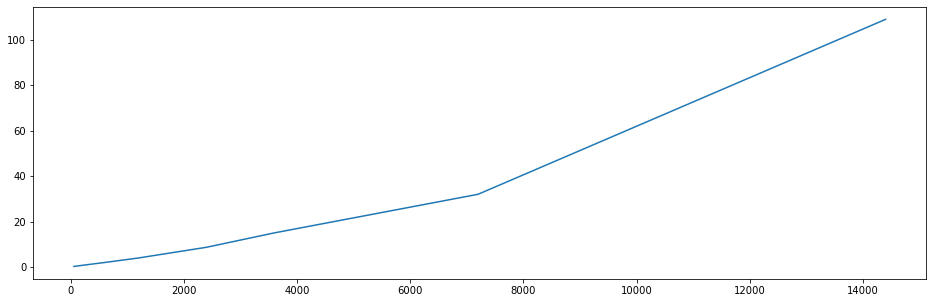

In [28]:
def autoPCA(x, n, k, approx=True, **args):
    """
    x : 1-dimensional array
    k : the number of highest eigenvalues/eigenvectors needed < n
    n : the size of the overlapping window
    approx : don't make minute edge effect corrections for minor improvements in accuracy
    returns the explained variance and the eigenvectors
    """
    x -= np.mean(x)
    if approx:
        xtx = la.toeplitz(np.correlate(x, x[:-n+1]))
    else:
        xtx = np.zeros([n,n])
        xtx[:,0] = np.correlate(x, x[:-n+1])
        delta = x[-n+1:, None] @ x[None, -n+1:] - x[:n-1, None] @ x[None, :n-1]
        for i in range(1,n):
            xtx[i:, i] = xtx[i-1:-1, i-1] + delta[i-1, i-1:]
    ev = la.eigh(xtx, eigvals=(n - k, n - 1), **args)
    if isinstance(ev, np.ndarray):
        return ev[::-1]/np.trace(xtx)
    else:
        return (ev[0][::-1]/np.trace(xtx), ev[1])

import time
nlist = [60, 120, 300, 600, 1200, 2400, 3600, 7200, 14400]
timing = np.empty_like(nlist, dtype=float)
for n, ncol in enumerate(nlist):
    timing[n] = 0.0 - time.perf_counter()
    ev = autoPCA(x, ncol, 3, eigvals_only=True, overwrite_a=True, check_finite=False)
    timing[n] += time.perf_counter()
    print(n, ncol, timing[n], ev)

plt.plot(nlist, timing)

This result is amazing. In 15 seconds we were able to do a window size of 3600 seconds (1 hour!), where initially, a size of more than 60 seconds consumed all our resources. Just goes to show that persistence can (sometimes) pay off.

## Idea 9

Since we are looking for the eigenvalues of a Toeplitz matrix, there may be better/faster methods designed to take advantages of special features of Toeplitz matrices. For eigen-values often there is a tradeoff between fast and precise. My quick search turned up many papers, but no implementations. At this point, this is good enough for me, but someone may want to take it further. (One reference was by William F Trench [here](http://ramanujan.math.trinity.edu/wtrench/research/papers/TRENCH_TN_12.PDF))

## Postscript

Now the only thing that remains to explain is why it took me four days to write eight lines of code. 
